In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType
import pyspark.sql.functions as F

# Initialize Spark Session
spark = SparkSession.builder.getOrCreate()
filename = "data.everef.net/market-orders/history/2023/2023-01-01/market-orders-2023-01-01_00-15-03.v3.csv.bz2"
df = spark.read.option("compression", "bzip2") \
               .option("header", "true") \
               .option("inferSchema", "true") \
               .csv(filename)


24/12/10 23:01:56 WARN Utils: Your hostname, minas-ithil resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/10 23:01:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/10 23:01:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

In [2]:
sells = df.alias("sell").where(F.col("is_buy_order") == False)
buys = df.alias("buy").where(F.col("is_buy_order") == True)

arbs = sells.crossJoin(buys)\
.where("sell.type_id = buy.type_id")\
.where("sell.price < buy.price")\
.where("sell.volume_remain > buy.min_volume")

In [3]:
arbs.show()

24/12/10 23:02:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/10 23:02:12 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+--------+------------+-------------------+-----------+----------+----------+-----+------+---------+-------+-------------+------------+---------+-------------------+----------+----------------+-----------+--------+------------+-------------------+-----------+----------+----------+-----+-----------+---------+-------+-------------+------------+---------+-------------------+----------+----------------+-----------+
|duration|is_buy_order|             issued|location_id|min_volume|  order_id|price| range|system_id|type_id|volume_remain|volume_total|region_id| http_last_modified|station_id|constellation_id|universe_id|duration|is_buy_order|             issued|location_id|min_volume|  order_id|price|      range|system_id|type_id|volume_remain|volume_total|region_id| http_last_modified|station_id|constellation_id|universe_id|
+--------+------------+-------------------+-----------+----------+----------+-----+------+---------+-------+-------------+------------+---------+-------------------+-----

In [4]:
arbs.take(1)

[Row(duration=90, is_buy_order=False, issued=datetime.datetime(2022, 12, 23, 12, 33, 7), location_id=60012124, min_volume=1, order_id=6403786171, price=5.0, range='region', system_id=30000005, type_id=34, volume_remain=5560996, volume_total=5560996, region_id=10000001, http_last_modified=datetime.datetime(2022, 12, 31, 19, 11, 40), station_id=60012124, constellation_id=20000001, universe_id='eve', duration=14, is_buy_order=True, issued=datetime.datetime(2022, 12, 26, 6, 31, 23), location_id=60002350, min_volume=1, order_id=6405737890, price=5.15, range='station', system_id=30001438, type_id=34, volume_remain=17192, volume_total=17192, region_id=10000016, http_last_modified=datetime.datetime(2022, 12, 31, 19, 15, 11), station_id=60002350, constellation_id=20000211, universe_id='eve')]

In [4]:
import networkx as nx
import csv

with open("mapSolarSystemJumps.csv") as f:
    route_reader = csv.DictReader(f)

    G = nx.Graph()

    for row in route_reader:
        G.add_edge(int(row["fromSolarSystemID"]), int(row["toSolarSystemID"]))

In [6]:
@F.udf(returnType=IntegerType())
def get_distance(system_id1, system_id2):
    try:
        return len(nx.shortest_path(G, system_id1, system_id2))
    except (nx.exception.NodeNotFound, nx.exception.NetworkXNoPath):
        return -1

In [7]:
with_distances = arbs\
.withColumn("distance", get_distance("sell.system_id","buy.system_id"))\
.where("distance != -1")\
.cache()

In [8]:
wallet = 20_000_000

profits = with_distances\
.withColumn("available_volume", F.least(F.col("sell.volume_remain"), F.col("buy.volume_remain")))\
.withColumn("executed_volume", F.least(F.lit(wallet)/F.col("sell.price"), "available_volume"))\
.withColumn("profit", F.expr("(buy.price - sell.price) * executed_volume"))

profits.select("executed_volume", "profit").take(1)

returns = profits\
.withColumn("return_per_jump", 100*((1 + F.col("profit")/F.lit(wallet))**(1/F.col("distance")) - 1))\
.sort(F.desc("return_per_jump"))
returns.take(2)

[Row(duration=90, is_buy_order=False, issued=datetime.datetime(2022, 11, 22, 16, 42, 7), location_id=60014632, min_volume=1, order_id=6330898561, price=148.0, range='region', system_id=30003522, type_id=1824, volume_remain=145000, volume_total=250000, region_id=10000043, http_last_modified=datetime.datetime(2022, 12, 31, 19, 13, 37), station_id=60014632, constellation_id=20000514, universe_id='eve', duration=90, is_buy_order=True, issued=datetime.datetime(2022, 12, 31, 17, 50, 17), location_id=60008494, min_volume=1, order_id=6405747894, price=3028.0, range='station', system_id=30002187, type_id=1824, volume_remain=75752, volume_total=100000, region_id=10000043, http_last_modified=datetime.datetime(2022, 12, 31, 19, 13, 37), station_id=60008494, constellation_id=20000322, universe_id='eve', distance=2, available_volume=75752, executed_volume=75752.0, profit=218165760.0, return_per_jump=245.08387386257274),
 Row(duration=7, is_buy_order=False, issued=datetime.datetime(2022, 12, 30, 14, 

In [9]:
returns.where("distance = 1").take(5)

[Row(duration=90, is_buy_order=False, issued=datetime.datetime(2022, 12, 13, 1, 48, 12), location_id=60010825, min_volume=1, order_id=6396104496, price=350.0, range='region', system_id=30004504, type_id=2679, volume_remain=13141, volume_total=173141, region_id=10000057, http_last_modified=datetime.datetime(2022, 12, 31, 19, 13, 3), station_id=60010825, constellation_id=20000657, universe_id='eve', duration=90, is_buy_order=True, issued=datetime.datetime(2022, 12, 31, 12, 23, 11), location_id=60010831, min_volume=1, order_id=6409667480, price=700.0, range='station', system_id=30004504, type_id=2679, volume_remain=50000, volume_total=50000, region_id=10000057, http_last_modified=datetime.datetime(2022, 12, 31, 19, 13, 3), station_id=60010831, constellation_id=20000657, universe_id='eve', distance=1, available_volume=13141, executed_volume=13141.0, profit=4599350.0, return_per_jump=22.996749999999988),
 Row(duration=365, is_buy_order=False, issued=datetime.datetime(2022, 12, 31, 17, 50, 2

In [10]:
with open("invTypes.csv") as f:
    inv_types = csv.DictReader(f)

    type_id_to_name = {}

    for row in inv_types:
        type_id_to_name[row["typeID"]] = row["typeName"]

In [25]:
best_volume = returns.groupBy("sell.type_id")\
.sum("available_volume")\
.sort(F.desc("sum(available_volume)"))\
.limit(10)\
.collect()

In [27]:
def annotate_name(rows):
    return [(type_id_to_name[str(row["type_id"])], row) for row in rows]

annotate_name(best_volume)

[('Tritanium', Row(type_id=34, sum(available_volume)=478817387999)),
 ('Pyerite', Row(type_id=35, sum(available_volume)=86592861549)),
 ('Heavy Water', Row(type_id=16272, sum(available_volume)=1917980054)),
 ('Mexallon', Row(type_id=36, sum(available_volume)=1513770852)),
 ('Tobacco', Row(type_id=9852, sum(available_volume)=1485866612)),
 ('Antibiotics', Row(type_id=43, sum(available_volume)=950118498)),
 ('Liquid Ozone', Row(type_id=16273, sum(available_volume)=947667179)),
 ('Quafe', Row(type_id=3699, sum(available_volume)=947450595)),
 ('Electronic Parts', Row(type_id=3687, sum(available_volume)=909353166)),
 ('Compressed Veldspar', Row(type_id=62516, sum(available_volume)=811322405))]

In [28]:
most_profit = best_volume = returns.groupBy("sell.type_id")\
.agg(F.sum(F.expr("(buy.price - sell.price) * available_volume")).alias("profit"))\
.sort(F.desc("profit"))\
.limit(10)\
.collect()

24/12/10 23:07:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
                                                                                

In [29]:
most_profit

[Row(type_id=34, profit=251979193921.50018),
 Row(type_id=35, profit=139701409157.43042),
 Row(type_id=33577, profit=104102325300.0),
 Row(type_id=3687, profit=85234927643.21085),
 Row(type_id=16272, profit=70756018468.4698),
 Row(type_id=43, profit=52584881173.960075),
 Row(type_id=16273, profit=41484893544.56001),
 Row(type_id=16275, profit=40870257881.6),
 Row(type_id=9850, profit=34183763140.05008),
 Row(type_id=3647, profit=24356005854.93002)]

In [30]:
annotate_name(most_profit)

[('Tritanium', Row(type_id=34, profit=251979193921.50018)),
 ('Pyerite', Row(type_id=35, profit=139701409157.43042)),
 ('Covert Research Tools', Row(type_id=33577, profit=104102325300.0)),
 ('Electronic Parts', Row(type_id=3687, profit=85234927643.21085)),
 ('Heavy Water', Row(type_id=16272, profit=70756018468.4698)),
 ('Antibiotics', Row(type_id=43, profit=52584881173.960075)),
 ('Liquid Ozone', Row(type_id=16273, profit=41484893544.56001)),
 ('Strontium Clathrates', Row(type_id=16275, profit=40870257881.6)),
 ('Spirits', Row(type_id=9850, profit=34183763140.05008)),
 ('Holoreels', Row(type_id=3647, profit=24356005854.93002))]

In [36]:
# volume weighted average prices
wavg_prices = df\
.withColumn("volume_x_price", F.expr("volume_remain * price"))\
.groupBy("type_id")\
.agg(F.sum("volume_remain").alias("volume"), F.sum("volume_x_price").alias("volume_x_price"))\
.withColumn("wavg_price", F.expr("volume_x_price/volume")).select("type_id", "wavg_price").cache()

In [41]:
arb_types = returns.join(wavg_prices, on="type_id").select("sell.type_id", "buy.price", "sell.price", "wavg_price").withColumn(
    "arb_type",
    F.when(F.col("sell.price") < F.col("wavg_price"), "cheap_seller")\
    .when(F.col("buy.price") > F.col("wavg_price"), "rich_buyer")\
    .otherwise("neither")
).cache()

In [46]:
agg_arb_types = arb_types.groupBy("type_id", "arb_type").count().sort(F.desc("count")).take(20)
annotate_name(agg_arb_types)

[('Carbon', Row(type_id=9826, arb_type='rich_buyer', count=165546)),
 ('Tobacco', Row(type_id=9852, arb_type='cheap_seller', count=148132)),
 ('Data Sheets', Row(type_id=3812, arb_type='rich_buyer', count=131529)),
 ('Antibiotics', Row(type_id=43, arb_type='rich_buyer', count=112950)),
 ('Electronic Parts', Row(type_id=3687, arb_type='cheap_seller', count=86661)),
 ('Garbage', Row(type_id=41, arb_type='cheap_seller', count=68118)),
 ('Spirits', Row(type_id=9850, arb_type='cheap_seller', count=61859)),
 ('Electronic Parts', Row(type_id=3687, arb_type='rich_buyer', count=60238)),
 ('Reports', Row(type_id=3814, arb_type='cheap_seller', count=56810)),
 ('Holoreels', Row(type_id=3647, arb_type='rich_buyer', count=49792)),
 ('Quafe', Row(type_id=3699, arb_type='cheap_seller', count=45671)),
 ('Soil', Row(type_id=3643, arb_type='rich_buyer', count=41737)),
 ('Frozen Food', Row(type_id=3715, arb_type='cheap_seller', count=33800)),
 ('Covert Research Tools',
  Row(type_id=33577, arb_type='rich_

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_eve_network(G, figsize=(20,20), method='spring', with_labels=True):
    """
    Plot EVE Online system network using different layout algorithms
    
    Parameters:
    G (networkx.Graph): NetworkX graph of systems
    figsize (tuple): Size of the figure (width, height)
    method (str): Layout algorithm ('spring', 'kamada_kawai', 'circular', 'random')
    with_labels (bool): Whether to show node labels
    """
    plt.figure(figsize=figsize)
    
    # Choose layout algorithm
    if method == 'spring':
        pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), iterations=50)
    elif method == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    elif method == 'circular':
        pos = nx.circular_layout(G)
    elif method == 'random':
        pos = nx.random_layout(G)
    else:
        raise ValueError("Unknown layout method")
    
    # Draw the network
    nx.draw(G, 
           pos=pos,
           node_color='lightblue',
           node_size=50,
           width=0.5,
           with_labels=with_labels,
           font_size=8,
           edge_color='gray',
           alpha=0.7)
    
    plt.title(f'EVE Online System Map ({method} layout)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3903/524429582.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


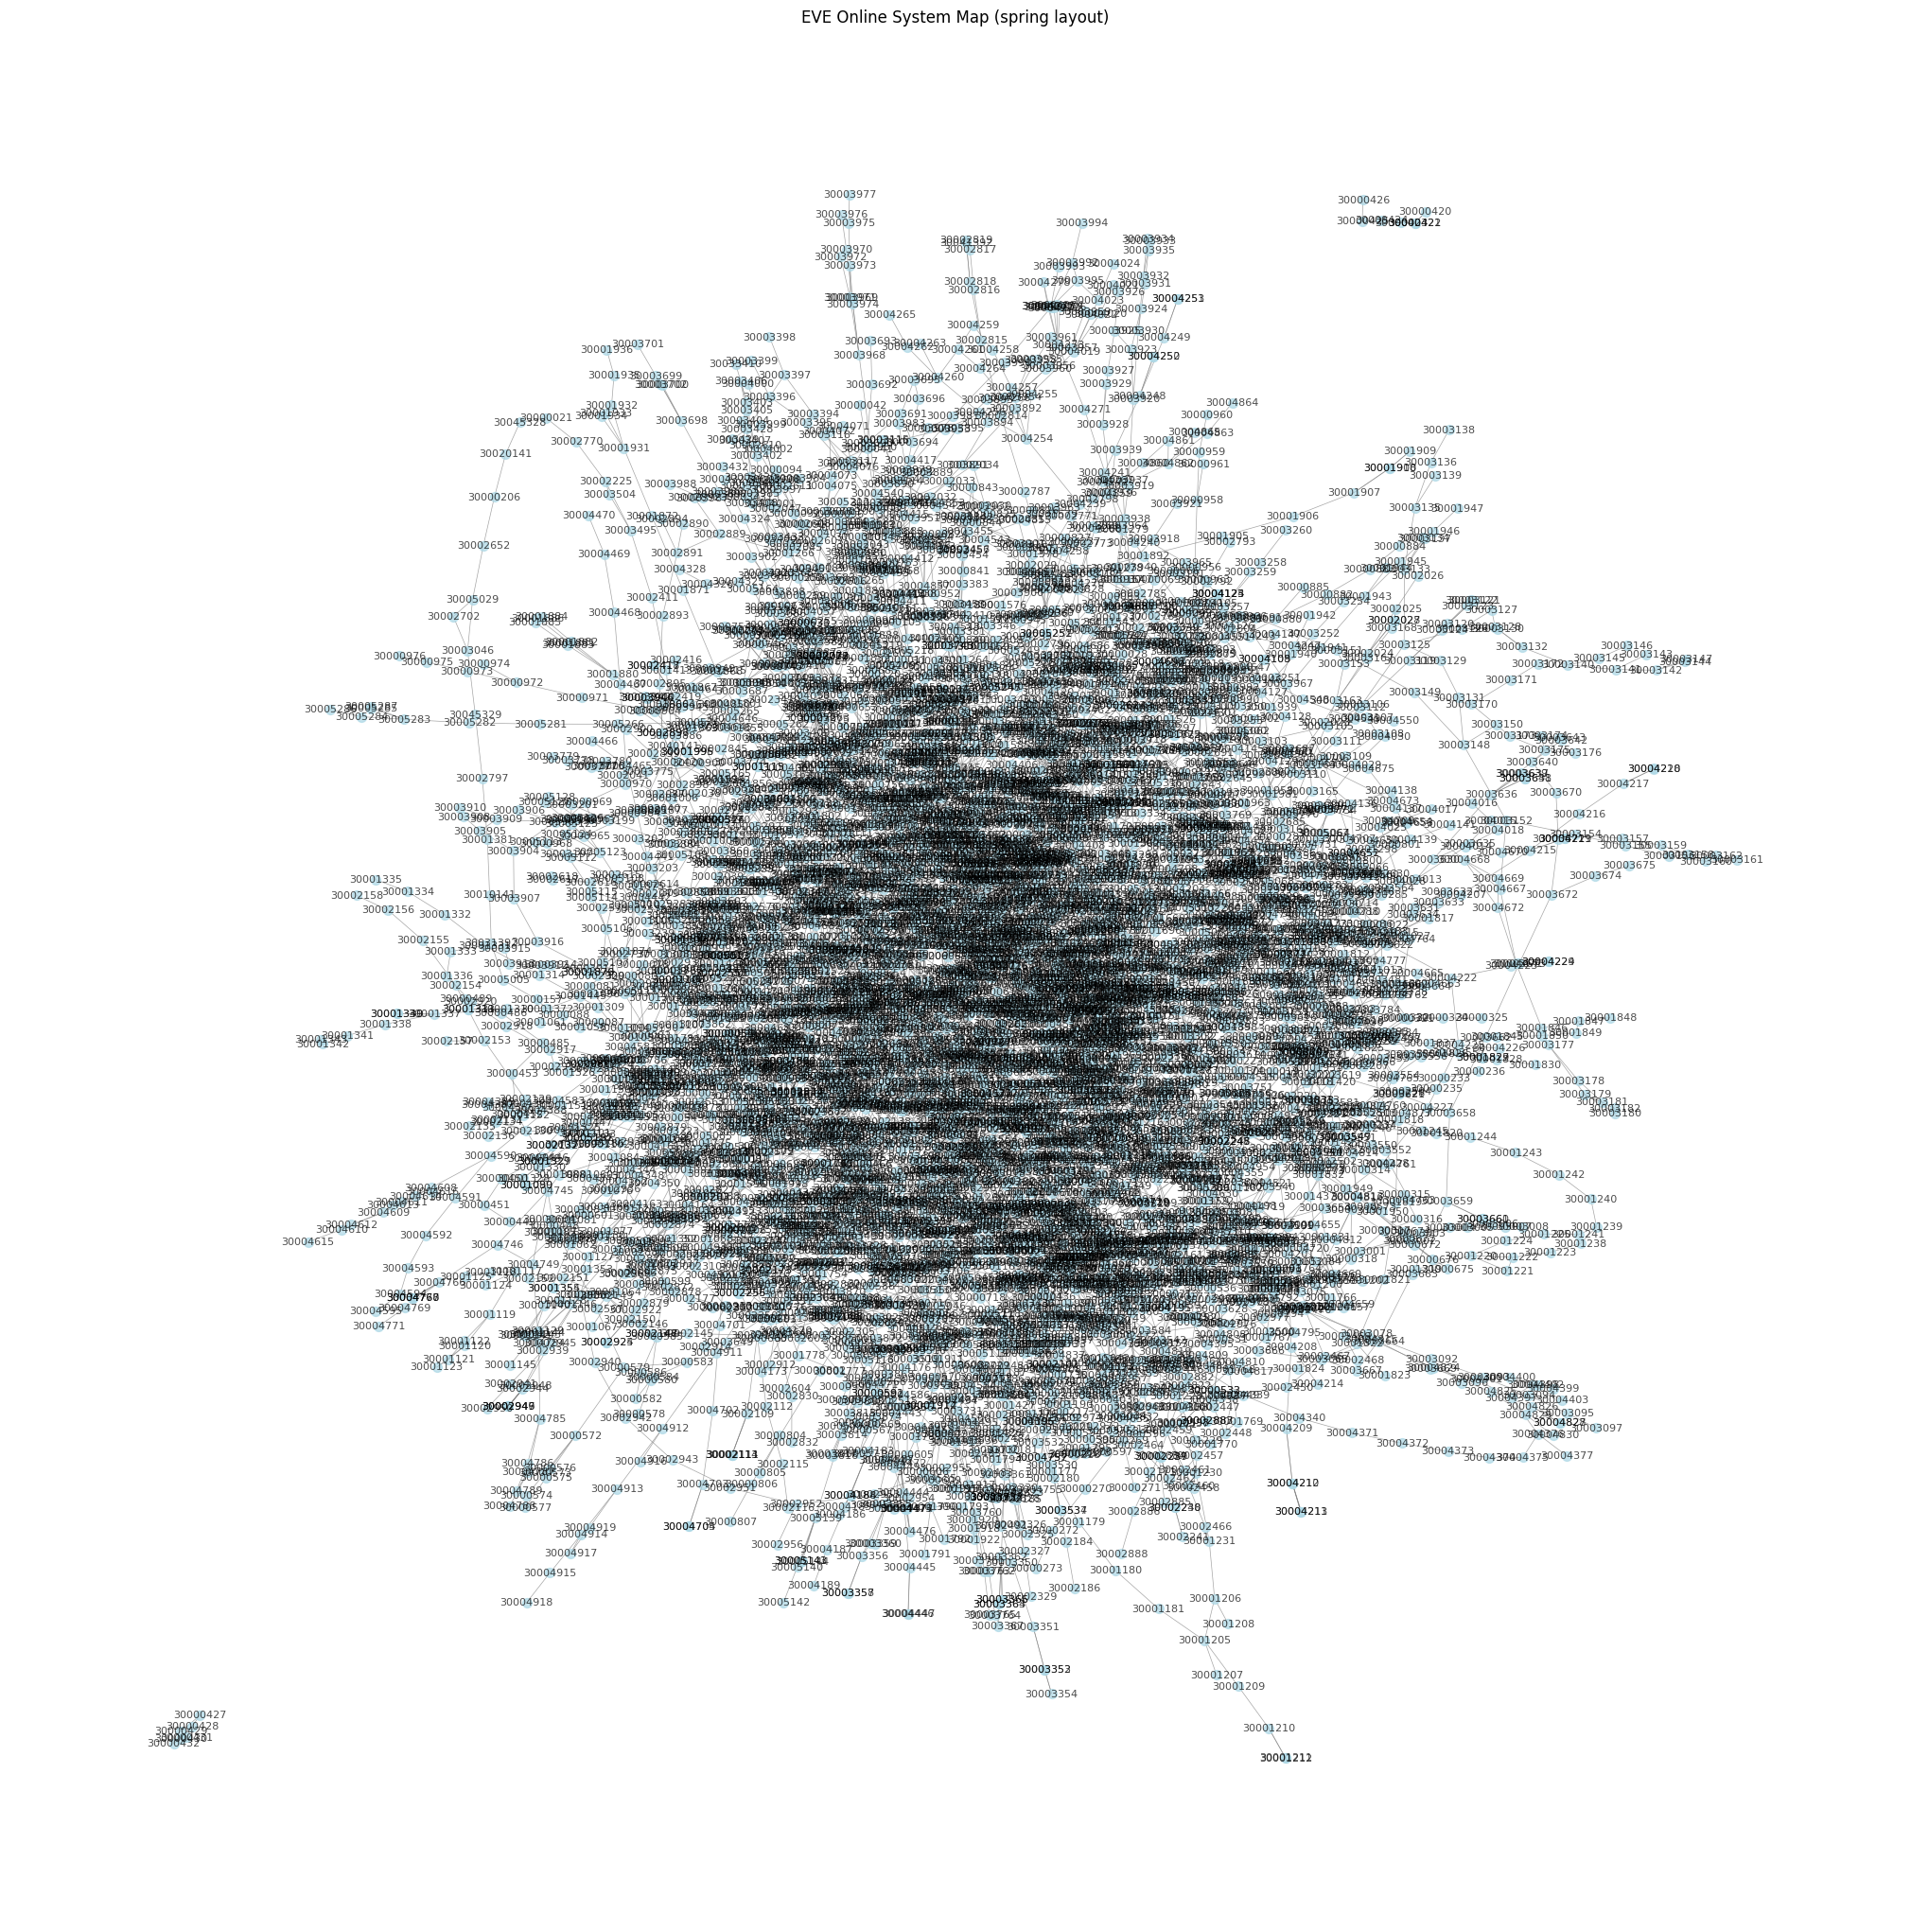

In [5]:
plot_eve_network(G)